In [18]:
import argparse, random, os
from PIL import Image
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from clip_illusion import Illusion
from utils.model_utils import load_vision_model
from utils.objectives import ClassConditionalObjective
from utils.config import Domain2Dict
from utils.feature_manipulation import counterfactual_explanation
from train_test_classifier import load_test_data, eval_loop, load_datasets
from scripts.inspect_class_mistakes import inspect_mistakes_in_class, vote_topk, aggregate_vote

In [19]:
domain_name = "imagenet"
class_dict = Domain2Dict[domain_name]

def prepare_model_and_illusion(model_name, device_id, class_gamma=0.35, domain_eps=0.05, ckpt_path=None):
    device = torch.device(f"cuda:{device_id}")
    transform, model, pool, decision, config = load_vision_model(model_name, device=device, ckpt_path=ckpt_path)
    illusion = Illusion(model, decision, ClassConditionalObjective(image_size=224, class_gamma=class_gamma, domain_eps=domain_eps), \
        class_dict=class_dict, device=f"cuda:{device_id}", img_mean=config["mean"], img_std=config["std"])
    
    return model, illusion, {"transform": transform, "pool": pool, "decision": decision}

def inference_one_sample(model, image_path, device):
    image = Image.open(image_path).convert("RGB")
    image = transforms.ToTensor()(image)
    image = image.unsqueeze(0).to(device)
    
    logits = model(image)
    pred = torch.argmax(logits, dim=-1)[0].item()
    
    return pred

In [35]:
device_id = 0
class_gamma = 0.6
domain_eps = 0.05
model_name = "resnet18"
ckpt_path = None#"ckpt/waterbird_resnet50/best_model.pt"

# Prepare model and CLIP-Illusion
model, illusion, modules = prepare_model_and_illusion(model_name, device_id, class_gamma, domain_eps, ckpt_path)
dimension = modules["decision"].weight.data.shape[1]

dataset_name = "imagenet"
data_dir= "../neuron_based_debugging/data/imagenet_val"
batch_size = 64

# Prepare test dataset
# train_dataset, valid_dataset, classes = load_datasets(dataset_name, data_dir)
valid_dataset, classes = load_test_data(dataset_name, data_dir, batch_size)
print("> The number of test samples: %d" % len(valid_dataset))
test_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

img_filelist = valid_dataset.samples

> The number of test samples: 50000


In [62]:
class_idx = 108

# set device
device = torch.device(device_id)

# Test the model
mistake_samples, mislabels, imp, class_features = inspect_mistakes_in_class(class_idx, len(classes), test_loader, img_filelist, model, device)
num_mistakes = len(mistake_samples)
print(f"> {model_name} has {num_mistakes} mistakes for the {dataset_name} dataset.")

Evaluating: 782it [01:35,  8.18it/s]

> resnet18 has 25 mistakes for the imagenet dataset.


In [64]:
import shutil

for path in mistake_samples[:10]:
    shutil.copy(path, ".")

In [101]:
class_dict = Domain2Dict[domain_name]
class_name = class_dict[class_idx].split(", ")[-1]

# Counterfactual explanation
print(f"> Inspecting mistakes for {class_name}...")
adjust_w = counterfactual_explanation(mistake_samples[1:2], modules["transform"], model, modules["pool"], \
                                    modules["decision"], device, class_idx=class_idx)
pos_vote = vote_topk(adjust_w, neg=False, k=5)
neg_vote = vote_topk(adjust_w, neg=True, k=5)
total_topk_pos = aggregate_vote(pos_vote, adjust_w.shape[0])
total_topk_neg = aggregate_vote(neg_vote, adjust_w.shape[0])
pos_ids = total_topk_pos.keys()
neg_ids = total_topk_neg.keys()

folder_class_name = class_name.replace(" ", "_")
exp_name = f"debug_resnet18_{dataset_name}_{folder_class_name}"

print("\n<Underlying Reasons>")
    
print("\n- Insufficient Properties:")
print(" Rank    ID  Prec@5 %  Importance")
print("--------------------------------")
skip = 0
for r, (n_id, v) in enumerate(total_topk_pos.items()):
    if n_id in neg_ids:
        skip+=1
        continue
    if r >= 15:
        break
    print("Top-%d: %4d  %2.3f   %.4f" % (r+1-skip, n_id, v, imp[n_id]))
print("--------------------------------")
        
print("\n- Excessive Properties:")
print(" Rank    ID  Prec@5 %  Importance")
print("--------------------------------")
skip = 0
for r, (n_id, v) in enumerate(total_topk_neg.items()):
    if n_id in pos_ids:
        skip+=1
        continue
    if r >= 15:
        break
    print("Top-%d: %4d  %2.3f   %.4f" % (r+1-skip, n_id, v, imp[n_id]))
print("--------------------------------\n")

> Inspecting mistakes for goldfish...
Progress 100.00 Optimizing iteration: 54, top neuron: 387   

<Underlying Reasons>

- Insufficient Properties:
 Rank    ID  Prec@5 %  Importance
--------------------------------
Top-1:  387  100.000   0.9006
Top-2:  451  100.000   1.0606
Top-3:    7  100.000   1.0629
Top-4:  167  100.000   0.9816
Top-5:  509  100.000   1.0361
--------------------------------

- Excessive Properties:
 Rank    ID  Prec@5 %  Importance
--------------------------------
Top-1:  294  100.000   1.3305
Top-2:  335  100.000   1.2734
Top-3:   68  100.000   1.2014
Top-4:  325  100.000   1.2759
Top-5:  370  100.000   1.2285
--------------------------------



In [99]:
neurons = [387, 451, 7, 167, 509]
target_neurons = torch.LongTensor(neurons)

In [100]:
from utils.prompts import prepare_class_names

# set neuron idx
illusion.objective_fn.channel_number = target_neurons.to(device)

# class_indices = []
# for neuron in neurons:
#     dummy = torch.zeros(batch_size, illusion.decision.weight.data.shape[1])
#     dummy[:,neuron] = 25.0
#     logits = illusion.decision(dummy.to(device))
#     class_indices.append(logits.argmax().item())
# class_indices = torch.LongTensor(class_indices).to(device)

class_idx = 1
class_indices = torch.LongTensor([class_idx for _ in range(target_neurons.shape[0])]).to(device)

illusion.objective_fn.class_idx = class_indices
# Generate Feature
class_names = prepare_class_names(class_indices, class_dict)

# Generate CLIP-Illusion
images, acts, masks = illusion.optimize_caption_and_dream(model.layer4, batch_size=target_neurons.shape[0], thresholding=False, \
                lr=9e-3, weight_decay=2e-4, iters=450, texts=class_names, quiet=False, reduction=0.5, threshold=0.0)

100%|██████████| 450/450 [00:16<00:00, 28.06it/s, loss=-18.9, lr=0.00108]


In [94]:
from PIL import Image


model(modules["transform"](Image.open(mistake_samples[0])).unsqueeze(0).to(device)).argmax(dim=1)

tensor([1], device='cuda:0')

In [88]:
mistake_samples[:1]

['../neuron_based_debugging/data/imagenet_val/n01914609/ILSVRC2012_val_00000017.JPEG']

In [18]:
viz, acts, masks = illusion.visualize_neurons(
    experiment_name=exp_name,
    target_neurons=target_neurons,
    layer=model.layer4,
    iters=450,
    lr=9e-3,
    batch_size=4,
    weight_decay=2e-4,
    class_idx=class_idx,
    thresholding=False,
    quiet=True,
)

Using existing sAMS folder at results/illusion
Experiment name: debug_resnet50_waterbird_aquatic_bird


Visualizing Neurons: 100%|██████████| 5/5 [01:30<00:00, 18.18s/it]


In [96]:
# torch.softmax(model(illusion.postprocess(images)), dim=-1)[:, class_idx]
probs = torch.softmax(model(illusion.postprocess(images)), dim=-1)
print(torch.argmax(probs,dim=1))
print(class_indices)
print(torch.gather(probs, 1, class_indices.unsqueeze(-1)).squeeze(1))

tensor([1, 1, 1, 1, 1], device='cuda:0')
tensor([1, 1, 1, 1, 1], device='cuda:0')
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


In [48]:
import torch.nn.functional as F


def select_spurious_attribute(model, illusion, class_idx, images, acts, masks, class_features, batch_size, reduction="mean"):
    with torch.no_grad():
        class_features = torch.cat(class_features, dim=0)
        
        features     = model.forward_features(illusion.postprocess(images))
        features_rev = model.forward_features(illusion.postprocess(images*masks))
        
        B, C, _, _ = features.shape
        if batch_size==1:
            features = features.view(B, C, -1).mean(dim=-1)
            features_rev = features_rev.view(B, C, -1).mean(dim=-1)
            acts = acts.squeeze(-1)
        else:
            num_n = B//batch_size
            acts = acts.view(num_n, batch_size)
            features = features.view(num_n, batch_size, C, -1).mean(dim=-1)
            features_rev = features_rev.view(num_n, batch_size, C, -1).mean(dim=-1)
            if reduction=="max":
                acts, index = acts.max(dim=1)
                index = index.view(num_n,1,1).expand(-1, 1, C)
                features = torch.gather(features, dim=1, index=index).squeeze(1)
                features_rev = torch.gather(features_rev, dim=1, index=index).squeeze(1)
            else:
                acts, _ = acts.min(dim=1)
                features = features.mean(dim=1)
                features_rev = features_rev.mean(dim=1)
        
        core_sensitivity = []
        for n in range(features.size(0)):
            corr = F.cosine_similarity(features[n:n+1], class_features.detach())
            corr_rev = F.cosine_similarity(features_rev[n:n+1], class_features.detach())
            sensitivity = corr_rev / corr
            top_cls = torch.topk(corr, k=1, dim=0, largest=True)[1]
            sen_cls = sensitivity[class_idx].item()
            
            # sen_remain = (sensitivity.sum()-sen_cls) / (sensitivity.size(0)-1)
            sen_remain = (sensitivity[top_cls].sum() / len(top_cls))
            print(sen_cls, sen_remain)
            core_sensitivity.append((sen_cls / sen_remain).item())
            
            # spurious[n] = sensitivity.min(dim=0)[0].item() <= sen_cls
            # print(sensitivity.min(dim=0)[0].item(), sen_cls)
        
        acts = acts.cpu()
        # selected = torch.logical_or(spurious, acts==0.0)
        # if selected.sum()==0:
        #     print(sensitivity)
        #     raise NotImplementedError("No spurious attribute is found.")
                        
        return core_sensitivity


In [23]:
n_mask = select_spurious_attribute(model, illusion, class_idx, viz, acts, masks, class_features, batch_size=4)

1.0574605464935303 tensor(1.0575, device='cuda:6')
1.0732442140579224 tensor(1.0732, device='cuda:6')
1.0616556406021118 tensor(1.0617, device='cuda:6')
0.9995388388633728 tensor(0.9995, device='cuda:6')
1.0722997188568115 tensor(1.0723, device='cuda:6')


In [119]:
n_mask

[0.9551315903663635,
 0.8029462099075317,
 1.1231348514556885,
 1.0059521198272705,
 1.0319976806640625,
 0.9907881617546082,
 0.9911674857139587,
 0.9744155406951904,
 0.9767997860908508,
 0.9381714463233948,
 0.9413388967514038,
 1.043230414390564,
 0.9855605363845825]

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


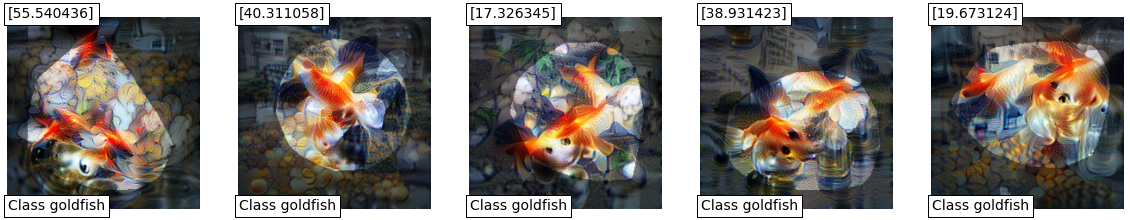

In [97]:
import matplotlib.pyplot as plt
from utils.ops import to_rgb
from PIL import Image

_images = to_rgb((images*(masks+0.5).clamp(max=1.0)).cpu().detach())
_acts = acts.cpu().detach().numpy()
neurons = target_neurons.tolist()

pil_images = [Image.fromarray(_images[i], "RGB") for i in range(len(neurons))]

fig, axes = plt.subplots(1,len(neurons))

fig.set_figheight(4)
fig.set_figwidth(4*len(neurons))

for i in range(len(neurons)):
    axes[i].imshow(pil_images[i]);
    axes[i].axis(False);
    axes[i].text(0.5, 0.5, _acts[i], fontsize=14, bbox=dict(facecolor="white"));
    axes[i].text(0.5, 224, "Class "+class_names[i].split(",")[0], fontsize=14, bbox=dict(facecolor="white"));
    axes[i].text(0.5, 224, f"Class {class_names[i]}", fontsize=14, bbox=dict(facecolor="white"));

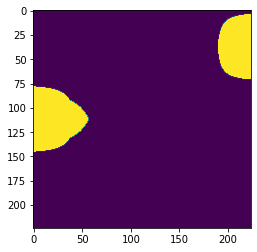

In [21]:
plt.imshow((masks[5,0]).cpu().detach())


In [22]:
# probs_pos = torch.softmax(model(illusion.postprocess(images*masks)),dim=-1)
# print(torch.gather(probs_pos, 1, class_indices.unsqueeze(-1)).squeeze(1))
probs_neg = torch.softmax(model(illusion.postprocess(images*(1.-masks))),dim=-1)
print(torch.gather(probs_neg, 1, class_indices.unsqueeze(-1)).squeeze(1))
probs = probs/probs_neg
# print(torch.argmax(probs,dim=1))
print(class_indices)
print(torch.gather(probs, 1, class_indices.unsqueeze(-1)).squeeze(1))

tensor([1.0000, 0.9984, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:1', grad_fn=<SqueezeBackward1>)
tensor([93, 93, 93, 93, 93, 93, 93, 93, 93, 93], device='cuda:1')
tensor([1.0000, 1.0016, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:1', grad_fn=<SqueezeBackward1>)
